In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from correlation_estimators import calculate_pearson
from sampling import pps, accept_reject
from scipy.stats.distributions import norm, expon

PROPERTY = 'fire_size'

dfo = pd.read_csv('./data/FW_Veg_Rem_Combined.csv')

cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]

def preprocess_missing_weather_data(df):
    df_subsample = df[df['Temp_pre_7'] == -1]
    df_clean = df[df['Temp_pre_7'] != -1]
    mean_weather_data = df_clean.groupby(['state', 'discovery_month'])[weather_columns].mean().reset_index()
    df_subsample.drop(weather_columns, axis=1, inplace=True)
    df_subsample = df_subsample.merge(mean_weather_data)
    df_clean = df_clean.append(df_subsample, ignore_index=True)
    return df_clean

df = preprocess_missing_weather_data(dfo)
df = pps(df, PROPERTY, 0.1)

df.stat_cause_descr.unique()


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array(['Debris Burning', 'Equipment Use', 'Miscellaneous', 'Arson',
       'Campfire', 'Lightning', 'Missing/Undefined', 'Fireworks',
       'Powerline', 'Children', 'Smoking', 'Railroad', 'Structure'],
      dtype=object)

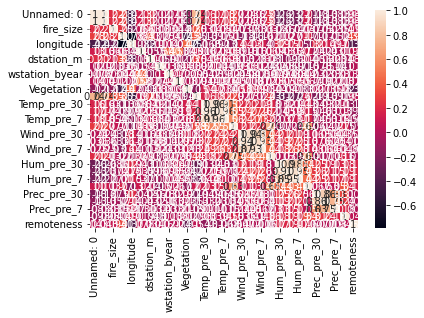

In [2]:
#correcaltion matrix

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [3]:
predictors_o = ['Temp_pre_7', 'Hum_pre_7', 'Wind_pre_7', 'Prec_pre_7', 'remoteness', 'latitude', 'longitude', 'Temp_cont', 'Hum_cont', 'Wind_cont', 'Prec_cont']

predictors = ['remoteness', 'latitude', 'longitude']

predictors += weather_columns

for pred in predictors:
    pr = calculate_pearson(df, pred, PROPERTY)
    print(f'The Pearsons coefficient for {PROPERTY} and {pred} is {pr}')


#Based on that we take: remoteness, latitude, longitute, Temp_pre_7, Temp_pre_15, Temp_pre_30, Prec_pre_30, Hum_pre_7, Hum_pre_15, Hum_pre_30

The Pearsons coefficient for fire_size and remoteness is 0.09445821912379518
The Pearsons coefficient for fire_size and latitude is 0.24530423633587337
The Pearsons coefficient for fire_size and longitude is -0.26936673152354373
The Pearsons coefficient for fire_size and Prec_pre_7 is -0.03481073853796775
The Pearsons coefficient for fire_size and Prec_pre_15 is -0.05176651126854519
The Pearsons coefficient for fire_size and Prec_pre_30 is -0.07514794377588019
The Pearsons coefficient for fire_size and Temp_pre_7 is 0.05405855820749528
The Pearsons coefficient for fire_size and Temp_pre_15 is 0.04269309934945352
The Pearsons coefficient for fire_size and Temp_pre_30 is 0.03098036301146489
The Pearsons coefficient for fire_size and Wind_pre_7 is -0.030161644651296934
The Pearsons coefficient for fire_size and Wind_pre_15 is -0.03275570786593924
The Pearsons coefficient for fire_size and Wind_pre_30 is -0.03739159477240544
The Pearsons coefficient for fire_size and Hum_pre_7 is -0.076506

In [4]:
#BAsesian network preparation

!git clone https://github.com/ITMO-NSS-team/BAMT.git
!pip install -r BAMT/requirements.txt

import os, sys

sys.path.append(os.path.join(os.path.dirname('./BAMT'), "BAMT"))

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

fatal: destination path 'BAMT' already exists and is not an empty directory.


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
bayesian_net_columns = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30', 'stat_cause_descr']
bayesian_net_columns_cont = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30']
to_drop = filter(lambda col: col != PROPERTY and not col in bayesian_net_columns, df.columns)

df_bayes = df.drop(to_drop, axis=1)

df_bayes.dropna(inplace=True)
df_bayes.reset_index(inplace=True, drop=True)
df_bayes.head(10)

,fire_size,stat_cause_descr,latitude,longitude,Temp_pre_30,Temp_pre_15,Temp_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,remoteness
0,30.18,Debris Burning,31.259000,-84.895600,20.079480,17.722714,18.188679,67.551783,61.733788,60.328571,0.0,0.162416
1,15.30,Equipment Use,36.586500,-96.323220,8.523263,5.933658,2.911842,76.615217,80.177291,85.369369,150.8,0.263943
2,5.00,Equipment Use,32.275940,-102.760900,6.224290,8.950698,8.880240,44.628895,32.515977,37.246939,0.0,0.327901
3,5.20,Miscellaneous,33.426303,-84.925226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.161130
4,1.00,Arson,40.746111,-75.748611,9.215850,9.625352,11.323707,66.972917,63.144681,65.285047,182.8,0.076025
5,10.00,Arson,33.370210,-98.447810,8.372812,7.059375,8.493939,61.569249,71.109474,78.982301,86.5,0.285984
6,3.80,Debris Burning,44.524631,-88.996043,0.578848,6.130116,7.645339,71.180254,68.552326,65.423729,40.2,0.192649
7,5.00,Debris Burning,31.560615,-96.291583,10.410706,13.517045,11.311230,63.708520,63.083721,56.908108,22.7,0.266943
8,10.00,Debris Burning,30.823796,-96.380568,28.834016,29.230492,29.885828,67.982322,65.747159,66.590818,0.0,0.268336
9,13.00,Debris Burning,34.080486,-83.861637,6.950617,0.000000,0.000000,58.975309,0.000000,0.000000,0.0,0.151147


In [6]:
nodes_type = get_nodes_type(df_bayes)
nodes_sign = get_nodes_sign(df_bayes)

nodes_type

{'fire_size': 'cont',
 'stat_cause_descr': 'disc',
 'latitude': 'cont',
 'longitude': 'cont',
 'Temp_pre_30': 'cont',
 'Temp_pre_15': 'cont',
 'Temp_pre_7': 'cont',
 'Hum_pre_30': 'cont',
 'Hum_pre_15': 'cont',
 'Hum_pre_7': 'cont',
 'Prec_pre_30': 'cont',
 'remoteness': 'cont'}

In [7]:
coded_data, coder = code_categories(df_bayes, 'label', ['stat_cause_descr'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', bayesian_net_columns_cont)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [9]:
#bn_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
#save_structure(bn_hc, 'struct_bnhc')
#bn_hc_params = parameter_learning(discrete_data, nodes_type, bn_hc, 'simple')
bn_hc = read_structure('struct_bnhc')
#save_params(bn_hc_params, 'params_bnhc')
bn_hc_params = read_params('params_bnhc')

bayes_hc = HyBayesianNetwork(bn_hc, bn_hc_params)

In [15]:
bn_evo_k2 = structure_learning(discrete_data, 'evo', nodes_type)
save_structure(bn_evo_k2, 'struct_evok2')
bn_evo_params = parameter_learning(discrete_data, nodes_type, bn_evo_k2, 'simple')
bn_evo_k2 = read_structure('struct_evok2')
save_params(bn_evo_params, 'params_evok2')
bn_evo_params = read_structure('params_evok2')

bayes_evok2 = HyBayesianNetwork(bn_evo_k2, bn_evo_params)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 13.229983056873703
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 1.9 min
Best metric is 13.170385326436989
Generation num: 1
max_depth: 6, no improvements: 0
spent time: 3.5 min
Best metric is 12.554400251694354
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 4.5 min
Best metric is 12.216226136850704
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 5.2 min
Best metric is 12.037526136850705
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 6.0 min
Best metric is 12.037526136850705
Generation num: 5
max_depth: 6, no improvements: 1
spent time: 6.8 min
Best metric is 11.941126136850706
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 7.6 min
Best metric is 10.707684635561694
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 8.3 min
Best metric is 10.706784635561696
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 9.1 min
Best metric is 10.520784635561693
Generation num: 9
max

FileNotFoundError: [Errno 2] No such file or directory: '/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/models/structure_bn/params_evok2.txt'

In [1]:
bn_hc_mi = structure_learning(discrete_data, 'HC', nodes_type, 'MI')
save_structure(bn_hc_mi, 'struct_hcmi')
bn_hcmi_params = parameter_learning(discrete_data, nodes_type, bn_hc_mi, 'simple')
save_params(bn_hcmi_params, 'params_hcmi')
bn_hc_mi = read_structure('struct_hcmi')
bn_hcmi_params = read_params(bn_hcmi_params, 'params_hcmi')

bayes_hcmi = HyBayesianNetwork(bn_hc_mi, bn_hcmi_params)

NameError: name 'structure_learning' is not defined

In [11]:
df_val = accept_reject(dfo, PROPERTY, norm, 10)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/sampling.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  if r_m <= (prob_needed/prob_current):
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/sampling.py:46: RuntimeWarning: invalid value encountered in double_scalars
  if r_m <= (prob_needed/prob_current):


In [14]:

calculate_acc(bayes_hc, df, ['fire_size'], 'simple')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

({},
 {'fire_size': 41773.895},
 [[30.18,
   15.3,
   5.0,
   5.2,
   1.0,
   10.0,
   3.8,
   5.0,
   10.0,
   13.0,
   1.0,
   2.0,
   1.0,
   1.0,
   10.0,
   4.0,
   4.0,
   2.0,
   6.0,
   2.0,
   9.0,
   5.0,
   25.0,
   13.0,
   6.0,
   912.0,
   10.0,
   2.0,
   160.0,
   0.8,
   15.0,
   1.1,
   1.0,
   2.0,
   0.8,
   1.0,
   35.0,
   3.0,
   1.95,
   5.0,
   0.75,
   1.0,
   1.0,
   4.0,
   30.0,
   2.0,
   3.0,
   10.0,
   4.0,
   10.0,
   5.0,
   10.0,
   1.0,
   5.0,
   10.0,
   2.5,
   0.6,
   1.0,
   3.5,
   2.0,
   250.0,
   20.0,
   320.0,
   4.0,
   4.0,
   5.0,
   275.0,
   1.5,
   1.12,
   3.0,
   2.0,
   3.0,
   6.0,
   3.0,
   200.0,
   1.0,
   3.0,
   30.0,
   1.0,
   2.0,
   18.0,
   30.0,
   15.0,
   3.0,
   1.0,
   1.0,
   1.0,
   7.0,
   35.0,
   1.0,
   139.0,
   10.0,
   5.0,
   12.0,
   2.0,
   30.0,
   2.5,
   140.0,
   40.0,
   0.75,
   1.0,
   1.0,
   4.0,
   2.0,
   2.71,
   1.0,
   1.0,
   35.0,
   22.0,
   15.0,
   1.0,
   30.0,
   3.0,
   7.0,
   1